### pass-vector decomposition:
    "passvec_dx"
    "passvec_dy"
    "passvec_length"
    "passvec_cos"
    "passvec_sin"
    "passvec_theta"
    "passvec_forward"
    "passvec_lateral"

In [47]:
from pathlib import Path
import os, sys

p = Path.cwd()
for _ in range(10):
    if (p / "environment.yml").exists() or (p / "README.md").exists():
        PROJECT_ROOT = p
        break
    p = p.parent
else:
    raise RuntimeError("Cannot find project root. Open the repo root in VS Code.")

sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(PROJECT_ROOT / "code"))

print("cwd =", Path.cwd())
print("PROJECT_ROOT =", PROJECT_ROOT)
print("code path exists =", (PROJECT_ROOT / "code").exists())

cwd = d:\visual-python\player-decision-simulation\Player-decision-simulation\notebooks\sandbox\ted
PROJECT_ROOT = d:\visual-python\player-decision-simulation\Player-decision-simulation
code path exists = True


In [75]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sys.dont_write_bytecode = True
DATA_ROOT = Path(r"D:\visual-python\player-decision-simulation\Player-decision-simulation\data\leverkusen_data")

CODE_DIR =  Path(r"D:\visual-python\player-decision-simulation\Player-decision-simulation\code")
assert CODE_DIR.exists(), f"CODE_DIR not found: {CODE_DIR}"

if str(CODE_DIR) not in sys.path:
    sys.path.insert(0, str(CODE_DIR))

print("DATA_ROOT:", DATA_ROOT)
print("CODE_DIR :", CODE_DIR)
print("sys.path[0]:", sys.path[0])

DATA_ROOT: D:\visual-python\player-decision-simulation\Player-decision-simulation\data\leverkusen_data
CODE_DIR : D:\visual-python\player-decision-simulation\Player-decision-simulation\code
sys.path[0]: d:\visual-python\player-decision-simulation\Player-decision-simulation\code


In [97]:
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from load_data import (
    find_seasons_for_competition,
    load_team_matches,
    find_matches_with_360,
    load_all_team_data,
    get_data_summary,
    print_data_summary,
)

from data_cleaning import (
    filter_valid_events,
    validate_data_consistency,
    identify_edge_cases,
)

from new_channel_ted import add_pass_vector_features
from feature_engineering import add_context_features_to_df
passes_ctx = add_context_features_to_df(
    passes_feat,
    context_dim=16
)

In [98]:

BASE_DIR = DATA_ROOT

print("BASE_DIR:", BASE_DIR)
print("competitions.json exists?", (BASE_DIR / "competitions.json").exists())

assert (BASE_DIR / "competitions.json").exists(), (
    "Cannot find competitions.json in leverkusen_data. "
    "Expected path: data/leverkusen_data/competitions.json"
)


BASE_DIR: D:\visual-python\player-decision-simulation\Player-decision-simulation\data\leverkusen_data
competitions.json exists? True


In [99]:
TEAM_NAME = "Bayer Leverkusen"
COMPETITION_ID = 9

seasons = find_seasons_for_competition(COMPETITION_ID, base_dir=str(BASE_DIR))
seasons_df = pd.DataFrame(seasons)

print("Seasons found:", len(seasons_df))
display(seasons_df.head(20))


Seasons found: 2


,competition_id,season_id,season_name,competition_name,country_name,match_available_360
0,9,281,2023/2024,1. Bundesliga,Germany,2025-07-06T04:26:07.636270
1,9,27,2015/2016,1. Bundesliga,Germany,None


In [100]:
if len(seasons) == 0:
    raise ValueError("No seasons found for this competition_id.")

cand = [s for s in seasons if s.get("match_available_360") in [True, "true", 1]]
SEASON_ID = cand[0]["season_id"] if cand else seasons[0]["season_id"]

print("Selected SEASON_ID:", SEASON_ID)

matches = load_team_matches(
    team_name=TEAM_NAME,
    competition_id=COMPETITION_ID,
    season_id=SEASON_ID,
    base_dir=str(BASE_DIR),
)

matches_df = pd.DataFrame(matches)
print("Leverkusen matches in this season:", len(matches_df))
display(matches_df.head(10))

Selected SEASON_ID: 281
Leverkusen matches in this season: 34


,match_id,match_date,home_team,away_team,home_score,away_score,is_home,competition_id,season_id,competition_name,season_name
0,3895302,2024-04-14,Bayer Leverkusen,Werder Bremen,5,0,True,9,281,1. Bundesliga,2023/2024
1,3895292,2024-04-06,Union Berlin,Bayer Leverkusen,0,1,False,9,281,1. Bundesliga,2023/2024
2,3895333,2024-05-05,Eintracht Frankfurt,Bayer Leverkusen,1,5,False,9,281,1. Bundesliga,2023/2024
3,3895340,2024-05-12,Bochum,Bayer Leverkusen,0,5,False,9,281,1. Bundesliga,2023/2024
4,3895348,2024-05-18,Bayer Leverkusen,Augsburg,2,1,True,9,281,1. Bundesliga,2023/2024
5,3895286,2024-03-30,Bayer Leverkusen,Hoffenheim,2,1,True,9,281,1. Bundesliga,2023/2024
6,3895220,2024-02-03,Darmstadt 98,Bayer Leverkusen,0,2,False,9,281,1. Bundesliga,2023/2024
7,3895250,2024-02-23,Bayer Leverkusen,FSV Mainz 05,2,1,True,9,281,1. Bundesliga,2023/2024
8,3895266,2024-03-10,Bayer Leverkusen,Wolfsburg,2,0,True,9,281,1. Bundesliga,2023/2024
9,3895275,2024-03-17,Freiburg,Bayer Leverkusen,2,3,False,9,281,1. Bundesliga,2023/2024


In [62]:
matches_with_360 = find_matches_with_360(matches, base_dir=str(BASE_DIR))
print("Matches with 360:", len(matches_with_360))
print("Example match ids:", matches_with_360[:10])

if len(matches_with_360) == 0:
    raise ValueError("No 360 matches found for this season/team combo. Try another SEASON_ID.")

Matches with 360: 34
Example match ids: [3895302, 3895292, 3895333, 3895340, 3895348, 3895286, 3895220, 3895250, 3895266, 3895275]


In [63]:
events_df, ff_df, player_stats = load_all_team_data(
    team_name=TEAM_NAME,
    matches=matches,
    matches_with_360=matches_with_360,
    base_dir=str(BASE_DIR),
    max_matches=1,  # ✅ keep small for validation
)

summary = get_data_summary(events_df, ff_df, player_stats, team_name=TEAM_NAME)
print_data_summary(summary)

display(events_df.head(5))

DATA SUMMARY - BAYER LEVERKUSEN
Total events:              2,315
Total freeze frame rows:   32,375
Unique matches:            0
Unique players:            16
Events with player_id:     2,308
Events with location:      2,299

Event types:
  Pass: 651
  Ball Receipt*: 639
  Carry: 587
  Pressure: 220
  Ball Recovery: 54
  Shot: 20
  Duel: 18
  Block: 16
  Dispossessed: 15
  Dribble: 14

Top 10 players by event count:
  Granit Xhaka: 287 events (85 passes) in 1 matches
  Robert Andrich: 269 events (88 passes) in 1 matches
  Edmond Fayçal Tapsoba: 261 events (87 passes) in 1 matches
  Odilon Kossonou: 234 events (77 passes) in 1 matches
  Jonathan Tah: 225 events (74 passes) in 1 matches
  Jonas Hofmann: 178 events (46 passes) in 1 matches
  Piero Martín Hincapié Reyna: 153 events (42 passes) in 1 matches
  Florian Wirtz: 138 events (27 passes) in 1 matches
  Nathan Tella: 122 events (24 passes) in 1 matches
  Amine Adli: 102 events (21 passes) in 1 matches


,event_id,match_id,team,player,type,minute,second,location,freeze_frame,visible_area,end_location,player_id,position
0,794ec549-5288-4d1a-93e8-0fc6d3968784,None,Bayer Leverkusen,None,Starting XI,0,0,None,[],[],NaN,NaN,NaN
1,1f956a2b-ece0-475b-8802-e82ed922c307,None,Bayer Leverkusen,None,Half Start,0,0,None,[],[],NaN,NaN,NaN
2,cfa1f5e1-4e8e-4fc2-bbc8-4df5fdef8283,None,Bayer Leverkusen,Amine Adli,Pressure,0,9,"[85.5, 15.4]","[{'teammate': False, 'actor': False, 'keeper':...","[62.93333229134909, 51.86733377543315, 63.4877...",NaN,33401.0,Left Attacking Midfield
3,a43fa179-91f5-4b22-9f74-7f20af0570e4,None,Bayer Leverkusen,Edmond Fayçal Tapsoba,Pressure,0,12,"[55.6, 14.8]","[{'teammate': True, 'actor': True, 'keeper': F...","[56.1869627760245, 47.301407450232034, 50.1282...",NaN,30606.0,Left Center Back
4,533ffee0-b9fc-4065-a9db-cb729523d926,None,Bayer Leverkusen,Jonathan Tah,Pressure,0,15,"[51.0, 15.8]","[{'teammate': True, 'actor': False, 'keeper': ...","[49.56201260049416, 50.80856566796838, 36.6254...",NaN,8221.0,Center Back


In [65]:
passes_feat = add_pass_vector_features(
    passes,
    start_col="location",
    end_col="end_location",
    attacking_left_to_right_col=None,   # no per-event direction column yet
    default_attacking_left_to_right=True,
    prefix="passvec_",
    drop_if_missing_end=True,
)

new_cols = [c for c in passes_feat.columns if c.startswith("passvec_")]
print("New columns:", new_cols)
display(passes_feat[new_cols].head(10))


New columns: ['passvec_dx', 'passvec_dy', 'passvec_length', 'passvec_cos', 'passvec_sin', 'passvec_forward', 'passvec_lateral', 'passvec_theta']


,passvec_dx,passvec_dy,passvec_length,passvec_cos,passvec_sin,passvec_forward,passvec_lateral,passvec_theta
6,-24.8,-9.4,26.521689,-0.935084,-0.354427,-24.8,-9.4,-2.779292
9,6.6,-12.3,13.958868,0.472818,-0.881160,6.6,-12.3,-1.078311
12,15.8,0.0,15.800000,1.000000,0.000000,15.8,0.0,0.000000
15,-8.2,0.0,8.200000,-1.000000,0.000000,-8.2,0.0,3.141593
18,0.5,21.1,21.105923,0.023690,0.999719,0.5,21.1,1.547104
21,1.9,11.8,11.951987,0.158969,0.987284,1.9,11.8,1.411150
24,-7.2,-10.2,12.485191,-0.576683,-0.816968,-7.2,-10.2,-2.185459
27,2.6,-30.4,30.510982,0.085215,-0.996363,2.6,-30.4,-1.485478
30,-0.7,23.4,23.410468,-0.029901,0.999553,-0.7,23.4,1.600702
33,20.9,20.8,29.486438,0.708800,0.705409,20.9,20.8,0.783000


In [ ]:
# 1) Missing rates
na_rate = passes_feat[new_cols].isna().mean().sort_values(ascending=False)
display(na_rate)

# 2) Basic ranges
desc = passes_feat[new_cols].describe(percentiles=[.01,.05,.5,.95,.99]).T
display(desc)

# 3) Sanity assertions
eps = 1e-6

# length >= 0 (ignoring NaN)
assert (passes_feat["passvec_length"].dropna() >= -eps).all(), "Found negative passvec_length"

# cos/sin in [-1,1] (ignoring NaN)
for c in ["passvec_cos","passvec_sin"]:
    x = passes_feat[c].dropna()
    assert ((x >= -1.0 - 1e-3) & (x <= 1.0 + 1e-3)).all(), f"{c} out of [-1,1]"

# cos^2 + sin^2 ~ 1 when length>0
mask = passes_feat["passvec_length"].fillna(0) > 1e-9
unit_norm = (passes_feat.loc[mask,"passvec_cos"]**2 + passes_feat.loc[mask,"passvec_sin"]**2)
print("Mean |(cos^2+sin^2)-1|:", float((unit_norm - 1.0).abs().mean()))

# theta in [-pi, pi]
theta = passes_feat["passvec_theta"].dropna()
assert ((theta >= -np.pi - eps) & (theta <= np.pi + eps)).all(), "theta out of [-pi, pi]"

print("All pass-vector channel checks passed.")


passvec_dx         0.0
passvec_dy         0.0
passvec_length     0.0
passvec_cos        0.0
passvec_sin        0.0
passvec_forward    0.0
passvec_lateral    0.0
passvec_theta      0.0
dtype: float64

,count,mean,std,min,1%,5%,50%,95%,99%,max
passvec_dx,651.0,3.134255,13.144525,-42.600000,-28.000000,-15.650000,2.400000,25.450000,44.350000,64.800000
passvec_dy,651.0,-0.362212,14.995935,-61.600000,-37.950000,-24.850000,0.000000,22.650000,34.350000,55.700000
passvec_length,651.0,17.239263,10.487005,1.838478,3.031139,6.212025,14.400347,37.337267,53.437800,68.087077
passvec_cos,651.0,0.126179,0.655421,-1.000000,-0.999442,-0.983979,0.158969,0.991129,0.999544,1.000000
passvec_sin,651.0,0.006294,0.745639,-1.000000,-0.999773,-0.994781,0.000000,0.996759,0.999949,1.000000
passvec_forward,651.0,3.134255,13.144525,-42.600000,-28.000000,-15.650000,2.400000,25.450000,44.350000,64.800000
passvec_lateral,651.0,-0.362212,14.995935,-61.600000,-37.950000,-24.850000,0.000000,22.650000,34.350000,55.700000
passvec_theta,651.0,0.084738,1.649964,-3.126209,-3.016855,-2.527037,0.054890,2.787028,3.098250,3.141593


Mean |(cos^2+sin^2)-1|: 9.482089119686437e-17
✅ All pass-vector channel checks passed.


In [67]:

plot_df = passes_feat.copy()
need = ["location", "end_location", "passvec_dx", "passvec_dy", "passvec_length",
        "passvec_cos", "passvec_sin", "passvec_forward", "passvec_lateral"]
plot_df = plot_df.dropna(subset=need)

def _xy(series_loc):
    # series_loc is like [x,y]
    return np.array([v[0] for v in series_loc]), np.array([v[1] for v in series_loc])

sx, sy = _xy(plot_df["location"])
ex, ey = _xy(plot_df["end_location"])

print("Plot rows:", len(plot_df))


Plot rows: 651


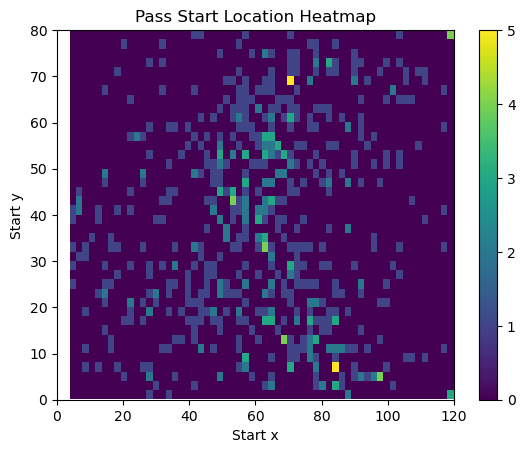

In [70]:
plt.figure()
plt.hist2d(sx, sy, bins=[60, 40])
plt.xlim(0, 120); plt.ylim(0, 80)
plt.xlabel("Start x"); plt.ylabel("Start y")
plt.title("Pass Start Location Heatmap")
plt.colorbar()
plt.show()


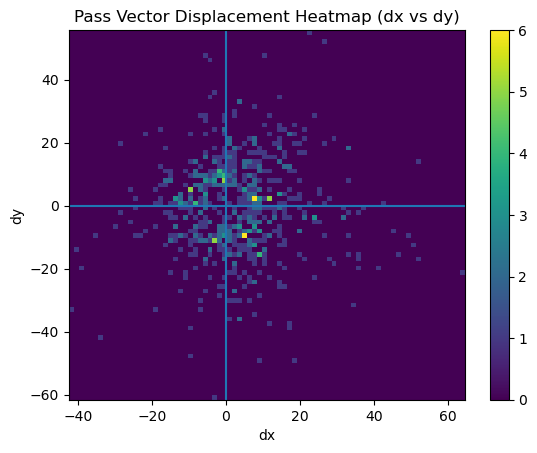

In [ ]:
dx = plot_df["passvec_dx"].to_numpy()
dy = plot_df["passvec_dy"].to_numpy()

plt.figure()
plt.hist2d(dx, dy, bins=80)
plt.axvline(0)
plt.axhline(0)
plt.xlabel("dx"); plt.ylabel("dy")
plt.title("Pass Vector Displacement Heatmap (dx vs dy)")
plt.colorbar()
plt.show()



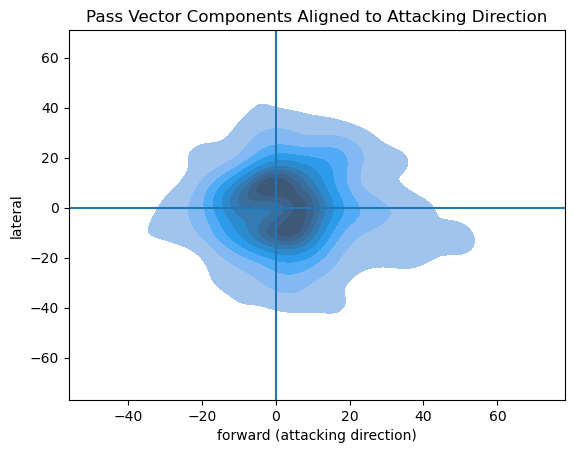

In [78]:
fw = passes_feat["passvec_forward"]
lat = passes_feat["passvec_lateral"]

sns.kdeplot(x=fw, y=lat, fill=True)
plt.axvline(0); plt.axhline(0)
plt.xlabel("forward (attacking direction)")
plt.ylabel("lateral")
plt.title("Pass Vector Components Aligned to Attacking Direction")
plt.show()

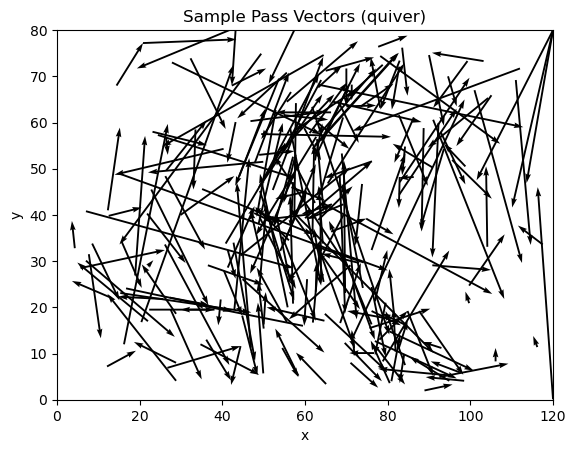

In [ ]:
rng = np.random.default_rng(0)
n = min(250, len(plot_df))
idx = rng.choice(len(plot_df), size=n, replace=False)
sub = plot_df.iloc[idx]

ssx, ssy = _xy(sub["location"])
ddx = sub["passvec_dx"].to_numpy()
ddy = sub["passvec_dy"].to_numpy()

plt.figure()
plt.quiver(ssx, ssy, ddx, ddy, angles="xy", scale_units="xy", scale=1)
plt.xlim(0, 120); plt.ylim(0, 80)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Sample Pass Vectors (quiver)")
plt.show()

Rows used: 651


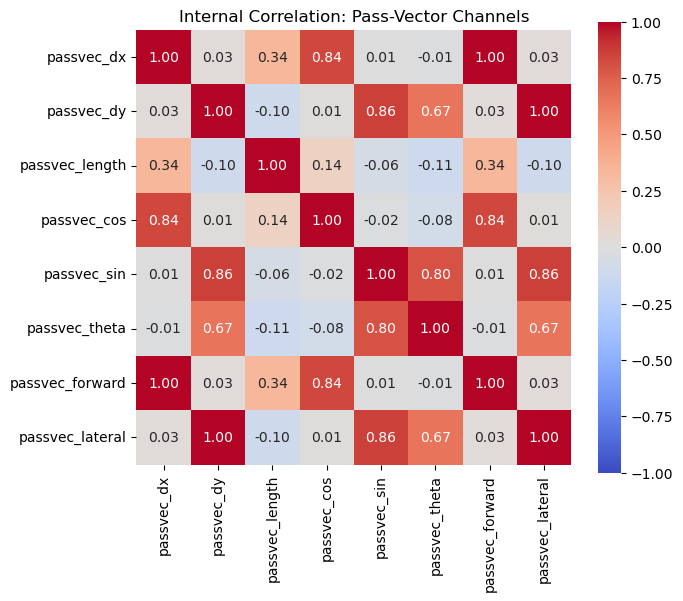

In [79]:
passvec_cols = [
    "passvec_dx",
    "passvec_dy",
    "passvec_length",
    "passvec_cos",
    "passvec_sin",
    "passvec_theta",
    "passvec_forward",
    "passvec_lateral",
]

df_pv = passes_feat[passvec_cols].dropna()

print("Rows used:", len(df_pv))

corr_pv = df_pv.corr(method="pearson")

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr_pv,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    square=True,
    annot=True,
    fmt=".2f"
)
plt.title("Internal Correlation: Pass-Vector Channels")
plt.tight_layout()
plt.show()

In [106]:

passvec_cols = [
    "passvec_dx",
    "passvec_dy",
    "passvec_length",
    "passvec_cos",
    "passvec_sin",
    "passvec_theta",
    "passvec_forward",
    "passvec_lateral",
]

context_semantic_map = {
    "pitch_zone":        [0, 1, 2, 3],     # zone encoding (4)
    "pressure_density":  [4, 5, 6],        # opp / tm / density
    "nearest_dist":      [7, 8],           # nearest opp / tm
    "lateral_pressure":  [9],              # pressure ratio
    "time_state":        [10],              # normalized time
    "phase_of_play":     [11],              # phase
    "counter_state":     [12],              # counter
    "set_piece":         [13],              # set piece
    "score_state":       [14, 15],           # score diff encoding
}

# 反向映射：context_i → semantic name
idx_to_semantic = {}
for name, idxs in context_semantic_map.items():
    for i in idxs:
        idx_to_semantic[f"context_{i}"] = name

imp_named = imp_df_sorted.copy()

imp_named["context_semantic"] = imp_named["context_channel"].map(
    idx_to_semantic
)

imp_named["context_semantic"] = imp_named["context_semantic"].fillna(
    imp_named["context_channel"]
)

imp_named = imp_named[
    ["passvec_channel", "context_semantic", "pearson_corr", "abs_corr"]
]

imp_named.head(20)

,passvec_channel,context_semantic,pearson_corr,abs_corr
0,passvec_dx,pitch_zone,0.220825,0.220825
96,passvec_forward,pitch_zone,0.220825,0.220825
48,passvec_cos,pitch_zone,0.182816,0.182816
71,passvec_sin,nearest_dist,-0.176436,0.176436
50,passvec_cos,pitch_zone,-0.175119,0.175119
87,passvec_theta,nearest_dist,-0.163641,0.163641
37,passvec_length,pressure_density,0.163640,0.163640
23,passvec_dy,nearest_dist,-0.162509,0.162509
119,passvec_lateral,nearest_dist,-0.162509,0.162509
98,passvec_forward,pitch_zone,-0.154077,0.154077
